
# Objective
This notebook demonstrates how blending the capabilities of Elasticsearch as a vector database (VectorDB), search templates, and LLM functions can provide an intelligent query layer.

<a target="_blank" href="https://colab.research.google.com/github/elastic/elasticsearch-labs/blob/main/supporting-blog-content/unifying-elastic-vector-database-and-llms-for-intelligent-query/Unifying_Elastic_Vector_Database_and_LLMs_for_Intelligent_Query.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


- **Elasticsearch as the VectorDB**: Acts as the core search engine, storing and retrieving dense vector embeddings efficiently.
- **Search Templates**: Marry index capabilities to query parameters, enabling dynamic query generation and structured search execution.
- **LLM Functions**: Parse the possible available parameters within a query and inject them into the search template for a more intelligent and context-aware retrieval process.

This combination enables a more sophisticated search experience, leveraging both structured and unstructured data retrieval methods.


In [ ]:
!pip install "elasticsearch==8.17.0" openai

In [ ]:
import os
import json
from openai import AzureOpenAI
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from elasticsearch import Elasticsearch, helpers, NotFoundError
import requests
from IPython.display import Markdown, display
import requests
from getpass import getpass

##Variables

##Elasticsearch Client

In [ ]:
es_cloud_id = getpass(prompt="Enter your Elasticsearch Cloud ID: ")
es_api_key = getpass(prompt="Enter your Elasticsearch API key: ")

es = Elasticsearch(cloud_id=es_cloud_id, api_key=es_api_key, timeout=300)

es.info()

## Get Completion Method

###Completions Endpoint & API Key

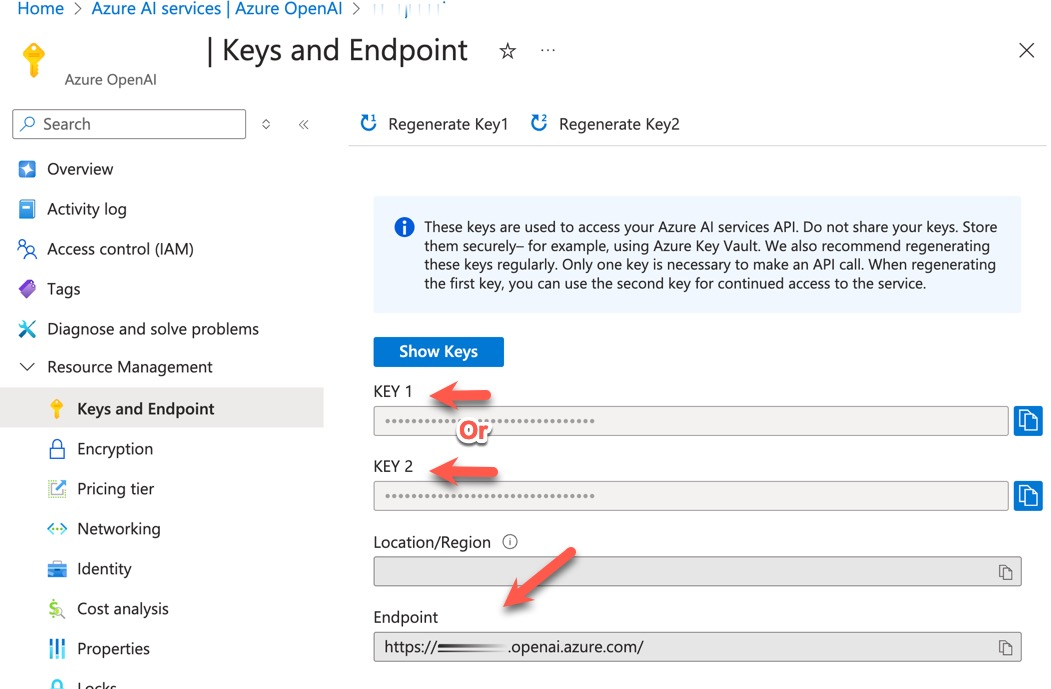

In [ ]:
ENDPOINT = getpass("Azure OpenAI Completions Endpoint: ")

AZURE_API_KEY = getpass("Azure OpenAI API Key: ")

###Deployment Name

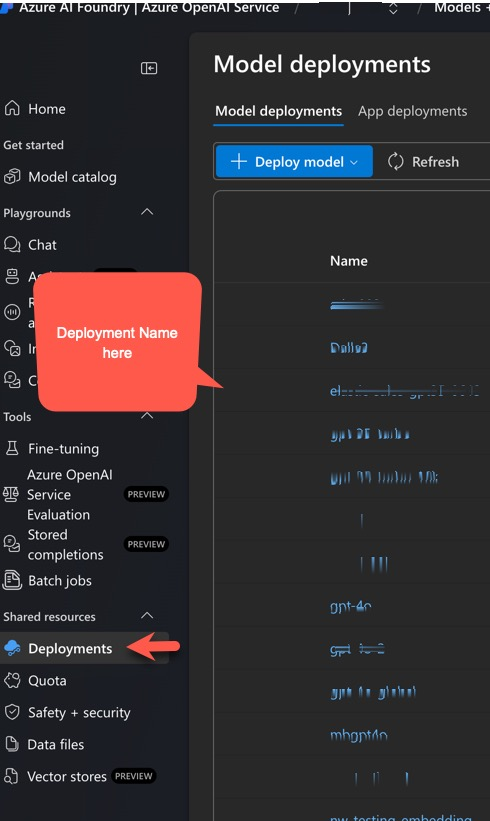

In [ ]:
DEPLOYMENT_NAME = getpass("Azure OpenAI Deployment Name: ")
deployment_name = DEPLOYMENT_NAME

###API Version

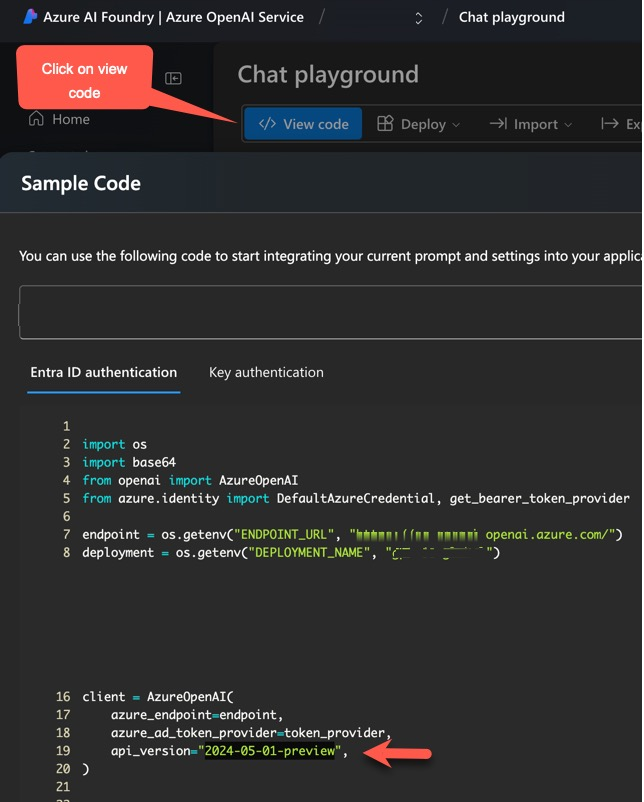

In [ ]:
API_VERSION = getpass("Completions Endpoint API Version: ")

client = AzureOpenAI(
    azure_endpoint=ENDPOINT, api_key=AZURE_API_KEY, api_version=API_VERSION
)

##Google Maps API Key Required

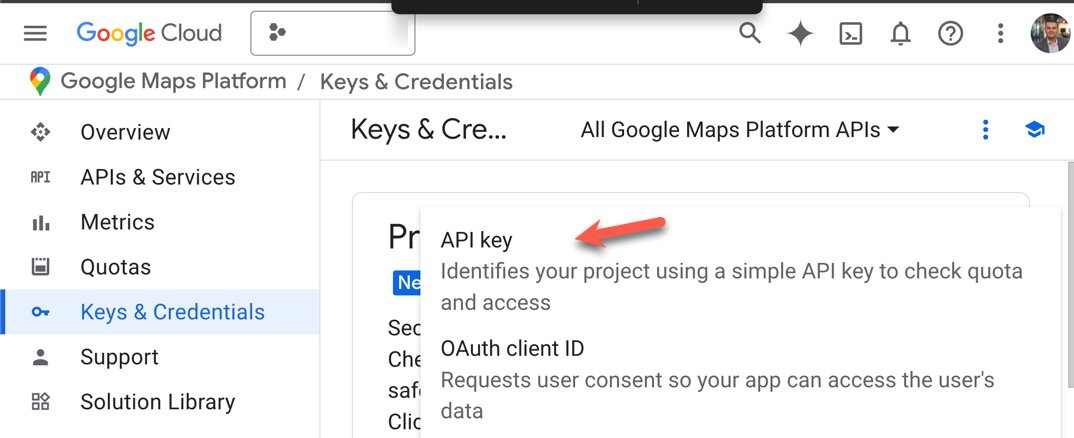

In [ ]:
##create google maps api key here: https://developers.google.com/maps/documentation/embed/get-api-key
GMAPS_API_KEY = getpass(prompt="Enter Google Maps API Key: ")
google_maps_api_key = GMAPS_API_KEY

In [ ]:
# Elastic index
ES_INDEX = "hotels"
TEMPLATE_ID = "hotel_search_template"

# JSON dataset URL
DATASET_URL = "https://ela.st/hotels-dataset"

ELSER_ENDPOINT_NAME = "my-e5-endpoint"
E5_ENDPOINT_NAME = "my-e5-endpoint"


# Define the index mapping
INDEX_MAPPING = {
    "mappings": {
        "properties": {
            "Address": {"type": "text"},
            "Attractions": {"type": "text"},
            "Description": {"type": "text"},
            "FaxNumber": {"type": "text"},
            "HotelCode": {"type": "long"},
            "HotelFacilities": {"type": "text"},
            "HotelName": {"type": "text"},
            "HotelRating": {"type": "long"},
            "HotelWebsiteUrl": {"type": "keyword"},
            "Map": {"type": "keyword"},
            "PhoneNumber": {"type": "text"},
            "PinCode": {"type": "keyword"},
            "cityCode": {"type": "long"},
            "cityName": {"type": "text"},
            "combined_fields": {
                "type": "text",
                "copy_to": ["semantic_description_elser", "semantic_description_e5"],
            },
            "countryCode": {"type": "keyword"},
            "countryName": {"type": "keyword"},
            "latitude": {"type": "double"},
            "location": {"type": "geo_point"},
            "longitude": {"type": "double"},
            "semantic_description_e5": {
                "type": "semantic_text",
                "inference_id": E5_ENDPOINT_NAME,
            },
            "semantic_description_elser": {
                "type": "semantic_text",
                "inference_id": ELSER_ENDPOINT_NAME,
            },
        }
    }
}

##Inferencing Endpoint Methods

In [ ]:
def create_inferencing_endpoints():
    endpoints = [
        {
            "inference_id": ELSER_ENDPOINT_NAME,
            "task_type": "sparse_embedding",
            "body": {
                "service": "elasticsearch",
                "service_settings": {
                    "num_allocations": 2,
                    "num_threads": 1,
                    "model_id": ".elser_model_2_linux-x86_64",
                },
                "chunking_settings": {
                    "strategy": "sentence",
                    "max_chunk_size": 250,
                    "sentence_overlap": 1,
                },
            },
        },
        {
            "inference_id": E5_ENDPOINT_NAME,
            "task_type": "text_embedding",
            "body": {
                "service": "elasticsearch",
                "service_settings": {
                    "num_allocations": 2,
                    "num_threads": 1,
                    "model_id": ".multilingual-e5-small",
                },
                "chunking_settings": {
                    "strategy": "sentence",
                    "max_chunk_size": 250,
                    "sentence_overlap": 1,
                },
            },
        },
    ]

    for endpoint in endpoints:
        try:
            es.inference.delete(inference_id=endpoint["inference_id"])
            print(f"Deleted endpoint '{endpoint['inference_id']}'")
        except NotFoundError:
            print(
                f"Endpoint '{endpoint['inference_id']}' does not exist. Skipping deletion."
            )

        response = es.inference.put(
            inference_id=endpoint["inference_id"],
            task_type=endpoint["task_type"],
            body=endpoint["body"],
        )
        print(f"Created endpoint '{endpoint['inference_id']}': {response}")

##Indexing and Ingestion Methods

In [ ]:
# Step 1: Create the index with mapping
def create_index():
    try:
        if es.indices.exists(index=ES_INDEX):
            print(f"Index '{ES_INDEX}' already exists. Deleting and recreating...")
            es.indices.delete(index=ES_INDEX)

        es.indices.create(index=ES_INDEX, body=INDEX_MAPPING)
        print(f"Index '{ES_INDEX}' created successfully.")
    except Exception as e:
        print(f"Error creating index: {e}")
        exit(1)


# Step 2: Download the JSON file
def download_json():
    print("Downloading dataset...")
    print(f"Using URL: {DATASET_URL}")

    # Start the request
    response = requests.get(DATASET_URL, stream=True)
    print(f"Received response with status code: {response.status_code}")

    # Check for errors
    try:
        response.raise_for_status()
        print("Response status is OK.")
    except requests.HTTPError as e:
        print(f"HTTP error occurred: {e}")
        raise

    # Optionally, show some headers (use carefully in production)
    print("Response headers:")
    for key, value in response.headers.items():
        print(f"  {key}: {value}")

    # Now return an iterator for the response lines
    print("Returning line iterator for the response content.")
    return response.iter_lines()


# Step 3: Ingest JSON records into Elasticsearch
def ingest_data():
    print("Ingesting data into Elasticsearch...")
    actions = []

    for line in download_json():
        if line:
            record = json.loads(line)
            # Convert latitude/longitude to geo_point format
            if "latitude" in record and "longitude" in record:
                record["location"] = {
                    "lat": record["latitude"],
                    "lon": record["longitude"],
                }

            actions.append({"_index": ES_INDEX, "_source": record})

            # Bulk index in batches of 50
            if len(actions) >= 50:
                helpers.bulk(es, actions)
                print(f"Ingested {len(actions)} records...")
                actions = []

    # Ingest any remaining records
    if actions:
        helpers.bulk(es, actions)
        print(f"Ingested {len(actions)} remaining records.")

    print("Data ingestion complete.")

##Search Template
Removes the existing hotel_search_template if present and replaces it with an updated version. This ensures the template is always current and correctly structured for search operations.

In [ ]:
# Search template content
search_template_content = {
    "script": {
        "lang": "mustache",
        "source": """{
            "_source": false,
            "fields": ["HotelName", "HotelRating", "countryName", "cityName", "countryCode", "Attractions"],
            "retriever": {
                "standard": {
                    "query": {
                        "semantic": {
                            "field": "semantic_description_elser",
                            "query": "{{query}}"
                        }
                    },
                    "filter": {
                        "bool": {
                            "must": [
                                {{#distance}}{
                                    "geo_distance": {
                                        "distance": "{{distance}}",
                                        "location": {
                                            "lat": {{latitude}},
                                            "lon": {{longitude}}
                                        }
                                    }
                                }{{/distance}}
                                {{#rating}}{{#distance}},{{/distance}}{
                                    "range": {
                                        "HotelRating": {
                                            "gte": {{rating}}
                                        }
                                    }
                                }{{/rating}}
                                {{#countryName}}{{#distance}}{{^rating}},{{/rating}}{{/distance}}{{#rating}},{{/rating}}{
                                    "term": {
                                        "countryName": "{{countryName}}"
                                    }
                                }{{/countryName}}
                                {{#city}}{{#distance}}{{^rating}},{{/rating}}{{/distance}}{{#rating}},{{/rating}}{
                                    "match": {
                                        "cityName": "{{city}}"
                                    }
                                }{{/city}}
                                {{#countryCode}}{{#distance}}{{^rating}},{{/rating}}{{/distance}}{{#rating}},{{/rating}}{
                                    "term": {
                                        "countryCode": "{{countryCode}}"
                                    }
                                }{{/countryCode}}
                                {{#distance}}{{^rating}}{{/rating}}{{/distance}}{{#rating}}{{/rating}}
                            ],
                            "should": [
                                {{#attraction}}{
                                    "wildcard": {
                                        "Attractions": {
                                            "value": "*{{attraction}}*",
                                            "case_insensitive": true
                                        }
                                    }
                                }{{/attraction}}
                            ]
                        }
                    }
                }
            }
        }""",
    }
}


def delete_search_template(template_id):
    """Deletes the search template if it exists"""
    try:
        es.delete_script(id=template_id)
        print(f"Deleted existing search template: {template_id}")
    except Exception as e:
        if "not_found" in str(e):
            print(f"Search template '{template_id}' not found, skipping delete.")
        else:
            print(f"Error deleting template '{template_id}': {e}")


def create_search_template(
    template_id=TEMPLATE_ID, template_content=search_template_content
):
    """Creates a new search template"""
    try:
        es.put_script(id=template_id, body=template_content)
        print(f"Created search template: {template_id}")
    except Exception as e:
        print(f"Error creating template '{template_id}': {e}")

## Find A Hotel Method
Manages interactions between user queries, LLM functions, and Elasticsearch, orchestrating tool calls to extract search parameters and execute queries.
"""

In [ ]:
def find_a_hotel(content):
    messages = [
        {
            "role": "system",
            "content": (
                "You are an assistant that only provides recommendations "
                "based on the search results retrieved from Elasticsearch. "
                "Do not make up information or answer based on assumptions. "
                "Only use the provided data to respond to the user's queries."
                "Don't make assumptions about what values to use with functions. Ask for clarification if a user request is ambiguous."
            ),
        },
        {"role": "user", "content": content},
    ]

    tools = [
        {
            "type": "function",
            "function": {
                "name": "extract_hotel_search_parameters",
                "description": "Extract search parameters for finding hotels (excluding the query itself).  the parameters are extracted from the input query",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "query": {
                            "type": "string",
                            "description": "the full input query",
                        },
                        "distance": {
                            "type": "string",
                            "description": "The search radius (e.g., 500m, 1000m).",
                        },
                        "rating": {
                            "type": "number",
                            "description": "The minimum hotel rating (e.g., 3, 4, or 5 stars).",
                        },
                        "location": {
                            "type": "string",
                            "description": "Location mentioned in the query (e.g., Belongil Beach, Byron Bay).",
                        },
                        "countryName": {
                            "type": "string",
                            "description": "Name of the country (e.g., Australia, Germany).",
                        },
                        "city": {
                            "type": "string",
                            "description": "City name (e.g., Byron Bay, Chicago, Houston).",
                        },
                        "State": {
                            "type": "string",
                            "description": "State or province (e.g., Texas, Alaska, Alberta).",
                        },
                        "countryCode": {
                            "type": "string",
                            "description": "The country code (e.g., AU for Australia).",
                        },
                        "attraction": {
                            "type": "string",
                            "description": "Hotel attractions, amenities, or descriptive terms (e.g., Beach, Museum, gym, modern, luxurious). This can include multiple options.",
                        },
                    },
                    "required": ["query", "attraction"],
                },
            },
        },
        {
            "type": "function",
            "function": {
                "name": "geocode_location",
                "description": "Resolve a location to its latitude and longitude.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "location": {
                            "type": "string",
                            "description": "The name of the location, e.g., Belongil Beach.",
                        }
                    },
                    "required": ["location"],
                },
            },
        },
        {
            "type": "function",
            "function": {
                "name": "query_elasticsearch",
                "description": "Query Elasticsearch for accommodations based on provided parameters from extract_hotel_search_parameters.  Must call extract_hotel_search_parameters prior to call this function ",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "query": {
                            "type": "string",
                            "description": "The original search query (e.g., 'hotels near Belongil Beach').",
                        },
                        "latitude": {
                            "type": "number",
                            "description": "Latitude of the location.",
                        },
                        "longitude": {
                            "type": "number",
                            "description": "Longitude of the location.",
                        },
                        "distance": {
                            "type": "string",
                            "description": "Search radius (e.g., '5000m', '10km').",
                        },
                        "rating": {
                            "type": "number",
                            "description": "Minimum hotel rating (e.g., 3, 4, 5 stars).",
                        },
                        "countryName": {
                            "type": "string",
                            "description": "The country name (e.g., 'Australia', 'United States').",
                        },
                        "countryCode": {
                            "type": "string",
                            "description": "The country code (e.g., 'AU', 'US').",
                        },
                        "attraction": {
                            "type": "string",
                            "description": "hotel attractions or amenity (e.g., Beach, Museum, gym, coffee shop, pool). This can be muliple options. Any feature of a hotel can be used here.  Attractions in the query may be obvious so this can be a comprehensive list",
                        },
                    },
                    "required": ["query"],
                },
            },
        },
    ]

    parameters = {}
    while True:
        # Call the LLM with tools
        response = client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            tools=tools,
            tool_choice="auto",
        )

        response_message = response.choices[0].message
        messages.append(response_message)

        # Print formatted messages for debugging
        print_messages([response_message])

        # Check for tool calls
        if response_message.tool_calls:
            for tool_call in response_message.tool_calls:
                function_name = tool_call.function.name
                function_args = json.loads(tool_call.function.arguments)

                if function_name == "extract_hotel_search_parameters":
                    # Debug: Print function_args
                    print("Function Arguments for extract_hotel_search_parameters:")
                    print(function_args)

                    # Extract required and optional parameters
                    function_response = handle_extract_hotel_search_parameters(
                        function_args
                    )

                    # Debug: Print function_response
                    print("Response from handle_extract_hotel_search_parameters:")
                    print(function_response)

                    parameters.update(json.loads(function_response))

                    # Debug: Print updated parameters
                    print("Updated parameters after extract_hotel_search_parameters:")
                    print(parameters)

                elif function_name == "query_elasticsearch":
                    # Ensure 'query' is present
                    if "query" not in parameters:
                        print("Error: 'query' is required for Elasticsearch queries.")
                        return None

                    print("Function Arguments for query_elasticsearch:")
                    print(function_args)

                    # Update parameters directly
                    # parameters.update(function_args)

                    # Pass extracted parameters to Elasticsearch
                    # function_response = call_elasticsearch(parameters)
                    function_response = call_elasticsearch(
                        query=function_args.get("query"),
                        latitude=function_args.get("latitude"),
                        attraction=function_args.get("attraction"),
                        longitude=function_args.get("longitude"),
                        distance=function_args.get("distance"),
                        rating=function_args.get("rating"),
                        country_name=function_args.get("countryName"),
                        country_code=function_args.get("countryCode"),
                    )

                elif function_name == "geocode_location":
                    function_response = geocode_location(
                        location=function_args.get("location")
                    )
                    geo_response = json.loads(function_response)
                    parameters.update(geo_response)

                    # Debug: Print updated parameters
                    print("Updated parameters after geocode_location:")
                    print(parameters)
                else:
                    function_response = json.dumps({"error": "Unknown function"})

                # Append the tool response to the conversation
                messages.append(
                    {
                        "tool_call_id": tool_call.id,
                        "role": "tool",
                        "name": function_name,
                        "content": json.dumps(function_response),
                    }
                )
        else:
            # If no further tools are requested, break the loop
            break

## Format and Print Messages Functions
Formats and prints ChatCompletionMessages for better readability, displaying roles, content, function calls, and tool interactions in a structured way.


In [ ]:
def format_message(message):
    """
    Format a ChatCompletionMessage for easier readability.
    """
    formatted_message = f"Role: {message.role}\n"
    if message.content:
        formatted_message += f"Content: {message.content}\n"
    if message.function_call:
        formatted_message += (
            f"Function Call:\n"
            f"  Name: {message.function_call.name}\n"
            f"  Arguments: {message.function_call.arguments}\n"
        )
    if message.tool_calls:
        formatted_message += "Tool Calls:\n"
        for tool_call in message.tool_calls:
            formatted_message += (
                f"  Tool Call ID: {tool_call.id}\n"
                f"  Function Name: {tool_call.function.name}\n"
                f"  Arguments: {tool_call.function.arguments}\n"
            )
    return formatted_message


def print_messages(messages):
    """
    Print all ChatCompletionMessages in a nicely formatted way.
    """
    print("\nFormatted Messages:")
    for i, message in enumerate(messages, 1):
        print(f"Message {i}:")
        print(format_message(message))
        print("-" * 50)

## Call Elasticsearch Function
Executes a search query using Elasticsearch with structured parameters, leveraging a search template for dynamic query generation.


In [ ]:
def call_elasticsearch(
    query,
    latitude=None,
    longitude=None,
    distance=None,
    rating=None,
    country_name=None,
    country_code=None,
    attraction=None,
):
    """
    Call Elasticsearch with the provided parameters and return a JSON-serializable response.
    """
    try:
        # Construct the params dictionary
        params = {
            "query": query,
            "latitude": latitude,
            "longitude": longitude,
            "distance": distance,
            "rating": rating,
            "countryName": country_name,
            "countryCode": country_code,
            "attraction": attraction,
        }

        # Remove None values
        cleaned_params = {
            key: value for key, value in params.items() if value is not None
        }

        # Debug: Print the parameters for Elasticsearch
        print("Parameters for Elasticsearch:")
        print(cleaned_params)

        # Construct the query body
        query_body = {
            "id": "hotel_search_template",  # Replace with your actual template ID
            "params": cleaned_params,
        }

        # Debug: Print query for Elasticsearch
        print("Elasticsearch Query:")
        print(json.dumps(query_body, indent=2))

        # Call Elasticsearch
        response = es.search_template(index=ES_INDEX, body=query_body)
        print("Elasticsearch query successful.")

        # Convert response to a JSON-serializable dictionary
        response_body = response.body

        # Extract and print the number of results
        total_results = response_body.get("hits", {}).get("total", {}).get("value", 0)
        print(f"Number of results found: {total_results}")

        return response_body
    except Exception as e:
        print(f"Error while querying Elasticsearch: {e}")
        return {"error": str(e)}

## Handle Extract Hotel Search Parameters Function
Validates and processes extracted search parameters, ensuring required values like distance are set for location-based hotel searches.

In [ ]:
def handle_extract_hotel_search_parameters(args):
    """
    Validate and handle parameters extracted by the LLM.
    """
    if "latitude" in args and "longitude" in args:
        if "distance" not in args:
            args["distance"] = "5000m"  # Default distance

    return json.dumps(args)

##Geo Location
Resolves a location name into latitude and longitude using Google Geocoding API for geospatial search integration.


In [ ]:
def geocode_location(location):
    """
    Resolve a location to latitude and longitude using Google Geocoding API.
    """
    GEOCODING_API_URL = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {"address": location, "key": google_maps_api_key}
    response = requests.get(GEOCODING_API_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        if data["status"] == "OK":
            result = data["results"][0]["geometry"]["location"]
            return json.dumps({"latitude": result["lat"], "longitude": result["lng"]})
    return json.dumps({"error": "Geocoding failed"})

##Create inferencing endpoints, Index, and Ingestion

In [ ]:
print("Creating inferencing endpoints...")
create_inferencing_endpoints()
print("Creating hotels index...")
create_index()
print("Ingesting hotels data...")
ingest_data()
print("Creating Search Template...")
create_search_template()

## Find a hotel
Here, issue a query and notice how the query understanding layer matches possible attributes in the query to the attributes supported within the hotels index.

In [19]:
find_a_hotel(
    "recently renovated accommodations 250m from Belongil Beach with at least 4 stars and with a pool and gym"
)


Formatted Messages:
Message 1:
Role: assistant
Tool Calls:
  Tool Call ID: call_VHhjy0TMxPnefibSssrTa5r0
  Function Name: extract_hotel_search_parameters
  Arguments: {"query":"recently renovated accommodations 250m from Belongil Beach with at least 4 stars and with a pool and gym","distance":"250m","rating":4,"location":"Belongil Beach","attraction":"recently renovated, pool, gym"}

--------------------------------------------------
Function Arguments for extract_hotel_search_parameters:
{'query': 'recently renovated accommodations 250m from Belongil Beach with at least 4 stars and with a pool and gym', 'distance': '250m', 'rating': 4, 'location': 'Belongil Beach', 'attraction': 'recently renovated, pool, gym'}
Response from handle_extract_hotel_search_parameters:
{"query": "recently renovated accommodations 250m from Belongil Beach with at least 4 stars and with a pool and gym", "distance": "250m", "rating": 4, "location": "Belongil Beach", "attraction": "recently renovated, pool, g